In [2]:
import quimb.tensor as qtn
import quimb as qu

import netket as nk
from vmc_torch.hamiltonian import spin_Heisenberg_square_lattice
import numpy as np
from math import pi

ndim = 2
L = 4
pbc = False
total_sz = 1/2 * (L**ndim % 2 == 1)
print(f"Total Sz = {total_sz}")
D = 2

# Build square lattice with nearest and next-nearest neighbor edges
# lattice = nk.graph.Square(L, max_neighbor_order=1, pbc=False)
g = lattice = nk.graph.Hypercube(L, ndim, pbc=pbc)
# g = lattice = nk.graph.Pyrochlore([L, L, L], pbc=pbc)

n = lattice.n_nodes
hi = nk.hilbert.Spin(s=1 / 2, total_sz=None, N=n)
# Heisenberg with coupling J=1.0 for nearest neighbors
# and J=0.5 for next-nearest neighbors
# H = nk.operator.Ising(hilbert=hi, graph=lattice, J=1.0, h=1.0)
H = nk.operator.Heisenberg(hilbert=hi, graph=lattice, J=1.0, sign_rule=False) # In Netket, the spin operators are Pauli matrices, while in Quimb they are 1/2*Pauli matrices

ham0 = spin_Heisenberg_square_lattice(L, J=1.0, pbc=pbc,total_sz=total_sz)
hi0 = ham0.hilbert

/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Total Sz = 0.0


In [3]:
# compute the ground-state energy (here we only need the lowest energy, and do not need the eigenstate)
evals = nk.exact.lanczos_ed(H, compute_eigenvectors=False)
exact_gs_energy = evals[0]
print('The exact ground-state energy is E0=',exact_gs_energy)

The exact ground-state energy is E0= -36.75682826077177


In [4]:
# # Arbitrary geometry tensor network
# psi = qtn.TN_rand_from_edges(lattice.edges(), D=D, phys_dim=2) # initialization from edges
# ham = qtn.LocalHamGen({edge: qu.ham_heis(2)*4 for edge in lattice.edges()})
# su = qtn.tensor_arbgeom_tebd.SimpleUpdateGen(
#     psi, 
#     ham,
#     compute_energy_every=10,
#     compute_energy_per_site=True,
# )
# for tau in [1.0, 0.3, 0.1, 0.03, 0.01]:
#     su.evolve(100, tau=tau)
# psi_su = su.state

In [5]:
# PEPS tensor network
psi = qtn.PEPS.rand(Lx=L, Ly=L, bond_dim=D, phys_dim=2) # initialization from PEPS
J=1.0
ham = qtn.ham_2d_heis(Lx=L, Ly=L, j=J*4)
su = qtn.tensor_arbgeom_tebd.SimpleUpdateGen(
    psi, 
    ham,
    compute_energy_every=10,
    compute_energy_per_site=True,
)
for tau in [1.0, 0.3, 0.1, 0.03, 0.01]:
    su.evolve(100, tau=tau)
psi_su = su.state

peps = su.get_state()
peps.equalize_norms_(value=1)

# save the state
params, skeleton = qtn.pack(peps)

# import os
# import pickle
# os.makedirs(f'../data/{L}x{L}/J={J}/D={D}', exist_ok=True)

# with open(f'../data/{L}x{L}/J={J}/D={D}/peps_skeleton.pkl', 'wb') as f:
#     pickle.dump(skeleton, f)
# with open(f'../data/{L}x{L}/J={J}/D={D}/peps_su_params.pkl', 'wb') as f:
#     pickle.dump(params, f)
    

n=500, tau=0.0100, energy~-2.107893: 100%|##########| 100/100 [00:02<00:00, 44.77it/s]


In [6]:
def from_netket_to_quimb_spin_config(config):
    """From (-1,1) to (0,1) basis"""
    def func(x):
        return (x + 1) / 2
    if len(config.shape) == 1:
        return func(config)
    else:
        return np.array([func(c) for c in config])

def get_amp(psi, config):
    return psi.isel({psi.site_inds[i]: int(s) for i, s in enumerate(config)})

def to_array(psi):
    return psi.to_dense()

def to_array_amps(psi, configs_netket):
    configs = from_netket_to_quimb_spin_config(configs_netket)
    return np.array([get_amp(psi, config).contract() for config in configs])

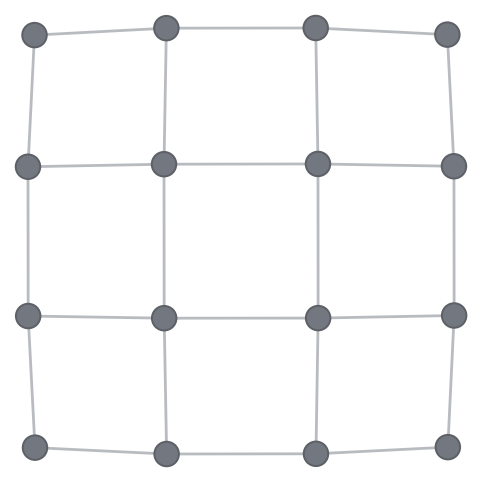

np.float64(-0.0005692602984663242)

In [7]:
psi = qtn.PEPS.rand(Lx=L, Ly=L, bond_dim=2*D, phys_dim=2) # initialization from PEPS
test_amp = get_amp(psi, from_netket_to_quimb_spin_config(hi0.all_states()[0]))
test_amp.draw()
test_amp.contract_boundary_from_ymin(xrange=None, yrange=(0,psi.Ly-1), max_bond=None).contract()

In [8]:
tn_w_proj = test_amp.contract_boundary_from(xrange=None, yrange=(0,psi.Ly-2), max_bond=2,cutoff=0.0, from_which='ymin',mode='projector2d',lazy=True, new_tags=['proj'])

In [1]:
tn0, proj_tn = tn_w_proj.partition('proj')

NameError: name 'tn_w_proj' is not defined

In [8]:
psi_vec = to_array_amps(psi_su, hi.all_states())

KeyboardInterrupt: 

In [8]:
hamiltonian = H.to_dense()

print("Energy from Quimb:", np.vdot(psi_vec, hamiltonian @ psi_vec).real / np.vdot(psi_vec, psi_vec).real)

Energy from Quimb: -7.359533130750947


In [9]:
# psi_su.view_as_(qtn.PEPS)
psi_su.compute_local_expectation(ham.terms, normalized=True, max_bond=32)

-7.359533130750947